In [57]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [58]:
ref_im = cv2.imread('form_example.png', 1)
scan_im = cv2.imread('form_example_scanned.jpg', 1)

(Text(0.5, 1.0, 'Scanned Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

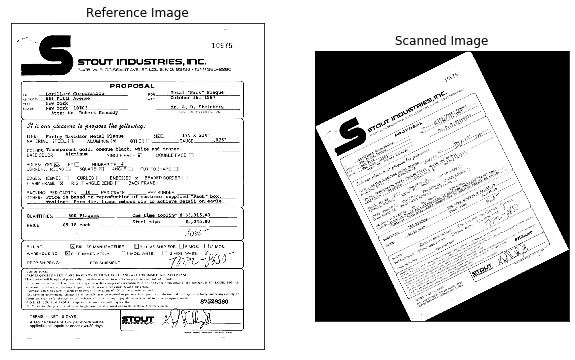

In [59]:
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(ref_im, cmap='gray')
plt.title('Reference Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(scan_im, cmap='gray')
plt.title('Scanned Image'), plt.xticks([]), plt.yticks([])

In [60]:
def get_corrected_img(img1, img2):
    MIN_MATCHES = 50

    orb = cv2.ORB_create(nfeatures=500)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # As per Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > MIN_MATCHES:
        src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        m, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        corrected_img = cv2.warpPerspective(img1, m, (img2.shape[1], img2.shape[0]))

        return corrected_img
    return img2


In [61]:
img = get_corrected_img(scan_im, ref_im)

(Text(0.5, 1.0, 'Aligned Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

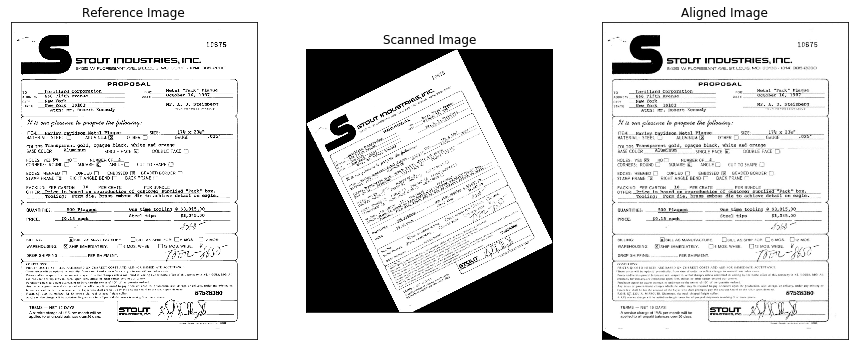

In [63]:
plt.figure(figsize=(15, 10))
plt.subplot(131), plt.imshow(ref_im, cmap='gray')
plt.title('Reference Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(scan_im, cmap='gray')
plt.title('Scanned Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img, cmap='gray')
plt.title('Aligned Image'), plt.xticks([]), plt.yticks([])

## Extract Text

In [64]:
fields = [
    {
        "id": 1,
        "x": 10.9756,
        "y": 20.9577,
        "w": 35.3659,
        "h": 1.45732,
        "label": 'to',
        "type": 0 # Text field
    },
    {
        "id": 2,
        "x": 10.9756,
        "y": 22.5538,
        "w": 35.3659,
        "h": 1.45732,
        "label": 'address',
        "type": 0 # Text field
    },
    {
        "id": 3,
        "x": 10.9756,
        "y": 23.9417,
        "w": 35.3659,
        "h": 1.45732,
        "label": 'city',
        "type": 0 # Text field
    }
]

## `pytesseract`

In [65]:
import pytesseract

In [66]:
out = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
import pandas as pd

df = pd.DataFrame(out)
for column in df.columns[:-1]:
    df['conf'] = df['conf'].astype(float)
df = df[df['conf'] > 50]

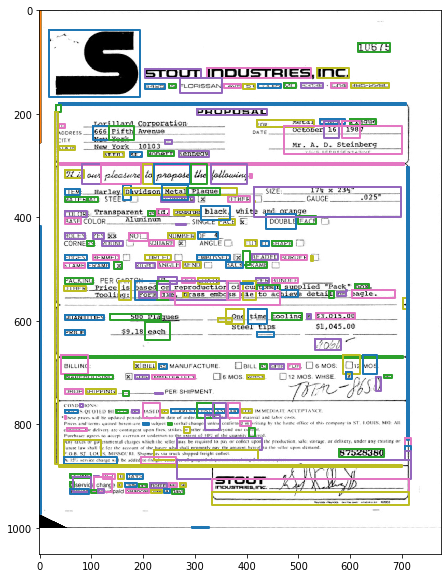

In [67]:
# Draw box using plt
def draw_boxes(x, y, w, h, color=(0, 255, 0)):
    plt.plot([x, x + w, x + w, x, x], [y, y, y + h, y + h, y], color, linewidth=2)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
for index, row in df.iterrows():
    draw_boxes(row['left'], row['top'], row['width'], row['height'])

plt.show()

(1000, 777, 3)
85 209 274 14


/Users/imadtoubal/anaconda3/envs/dlib/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/imadtoubal/anaconda3/envs/dlib/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


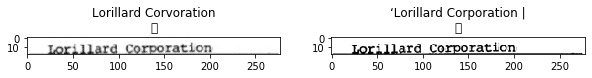

(1000, 777, 3)
85 225 274 14


/Users/imadtoubal/anaconda3/envs/dlib/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/imadtoubal/anaconda3/envs/dlib/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


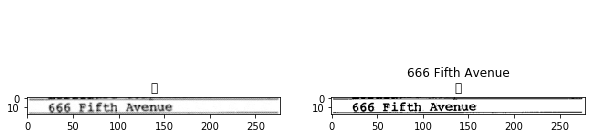

(1000, 777, 3)
85 239 274 14


/Users/imadtoubal/anaconda3/envs/dlib/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/imadtoubal/anaconda3/envs/dlib/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


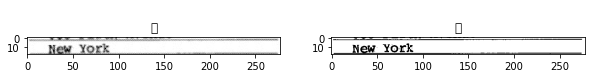

In [68]:
for field in fields:
    x = int(field['x'] * img.shape[1] / 100)
    y = int(field['y'] * img.shape[0] / 100)
    w = int(field['w'] * img.shape[1] / 100)
    h = int(field['h'] * img.shape[0] / 100)
    print(img.shape)
    print(x, y, w, h)
    p=2

    crop = img[y-p:y+h+p, x-p:x+w+p]
    crop_ref = ref_im[y-p:y+h+p, x-p:x+w+p]
    s1 = pytesseract.image_to_string(crop)
    s2 = pytesseract.image_to_string(crop_ref)
    # print(crop.shape)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1), plt.imshow(crop, cmap='gray')
    plt.title(s1)
    plt.subplot(1, 2, 2), plt.imshow(crop_ref, cmap='gray')
    plt.title(s2)
    plt.show()

## `easyocr`

In [69]:
import easyocr
reader = easyocr.Reader(['en'], gpu=False)


Using CPU. Note: This module is much faster with a GPU.


In [70]:
res = reader.readtext(img)

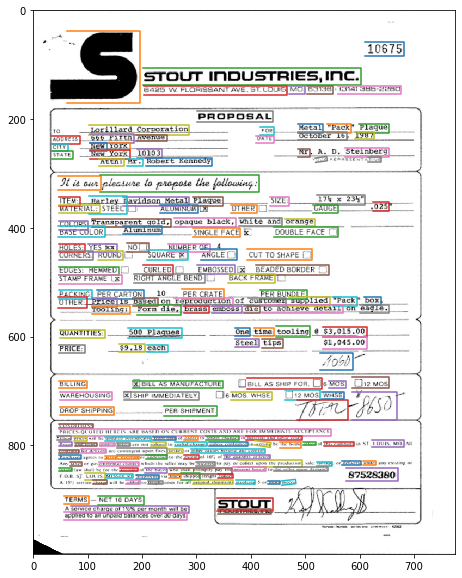

In [71]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
for r in res:
    points = np.array(r[0])
    plt.plot(points[:, 0], points[:, 1])
    # print(r[1])

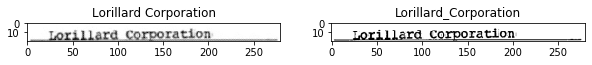

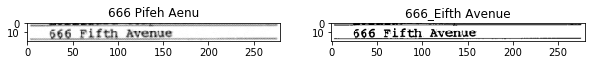

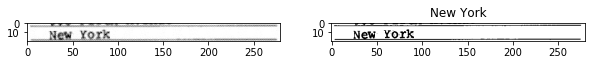

In [72]:
for field in fields:
    x = int(field['x'] * img.shape[1] / 100)
    y = int(field['y'] * img.shape[0] / 100)
    w = int(field['w'] * img.shape[1] / 100)
    h = int(field['h'] * img.shape[0] / 100)
    p=min(w, h) // 4

    crop = img[y-p:y+h+p, x-p:x+w+p]
    crop_ref = ref_im[y-p:y+h+p, x-p:x+w+p]
    words1 = [w[1] for w in reader.readtext(crop)]
    words2 = [w[1] for w in reader.readtext(crop_ref)]
    s1 = ' '.join(words1)
    s2 = ' '.join(words2)
    # print(crop.shape)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1), plt.imshow(crop, cmap='gray')
    plt.title(s1)
    plt.subplot(1, 2, 2), plt.imshow(crop_ref, cmap='gray')
    plt.title(s2)
    plt.show()